## Data Prep

In [99]:
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override()

df = pdr.get_data_yahoo("IBM")

[*********************100%%**********************]  1 of 1 completed


In [100]:
df.head


<bound method NDFrame.head of                   Open        High         Low       Close   Adj Close  \
Date                                                                     
1962-01-02    7.374124    7.374124    7.291268    7.291268    1.541710   
1962-01-03    7.291268    7.355003    7.291268    7.355003    1.555188   
1962-01-04    7.355003    7.355003    7.278521    7.281708    1.539689   
1962-01-05    7.272148    7.272148    7.125558    7.138305    1.509367   
1962-01-08    7.131931    7.131931    6.947100    7.004461    1.481066   
...                ...         ...         ...         ...         ...   
2024-04-17  184.160004  184.669998  181.779999  183.100006  183.100006   
2024-04-18  182.350006  183.460007  180.169998  181.470001  181.470001   
2024-04-19  182.429993  182.800003  180.570007  181.580002  181.580002   
2024-04-22  182.449997  183.320007  180.449997  181.899994  181.899994   
2024-04-23  182.729996  184.410004  182.020096  184.259995  184.259995   

       

In [101]:
reversed_df = df.iloc[::-1]

In [102]:
import numpy as np

def create_sequences(data, seq_length, prediction_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-prediction_length+1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length+prediction_length-1][4]  
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [103]:
# Split the data
split_fraction = 0.8
split = int(split_fraction * len(df))

# Split data into forward and backward sets
X_fwd = df.values
y_fwd = df.iloc[:, 4].values  # Assuming the target is at index 4

X_bkwd = reversed_df.values
y_bkwd = reversed_df.iloc[:, 4].values

X_train_fwd, X_test_fwd = X_fwd[:split], X_fwd[split:]
y_train_fwd, y_test_fwd = y_fwd[:split], y_fwd[split:]

X_train_bkwd, X_test_bkwd = X_bkwd[:split], X_bkwd[split:]
y_train_bkwd, y_test_bkwd = y_bkwd[:split], y_bkwd[split:]

In [104]:
# Scale the data
scaler_fwd = StandardScaler()
X_train_fwd_scaled = scaler_fwd.fit_transform(X_train_fwd)
X_test_fwd_scaled = scaler_fwd.transform(X_test_fwd)

scaler_bkwd = StandardScaler()
X_train_bkwd_scaled = scaler_bkwd.fit_transform(X_train_bkwd)
X_test_bkwd_scaled = scaler_bkwd.transform(X_test_bkwd)

In [105]:
# Create sequences for training data
seq_length = 5
prediction_length = 7
X_train_fwd_seq, y_train_fwd_seq = create_sequences(X_train_fwd_scaled, seq_length, prediction_length)
X_train_bkwd_seq, y_train_bkwd_seq = create_sequences(X_train_bkwd_scaled, seq_length, prediction_length)

# Create sequences for test data
X_test_fwd_seq, y_test_fwd_seq = create_sequences(X_test_fwd_scaled, seq_length, prediction_length)
X_test_bkwd_seq, y_test_bkwd_seq = create_sequences(X_test_bkwd_scaled, seq_length, prediction_length)

In [106]:
# Convert to PyTorch Datasets
batch_size = 64

#Forward
train_data_fwd = TensorDataset(torch.Tensor(X_train_fwd_seq), torch.Tensor(y_train_fwd_seq))
train_loader_fwd = DataLoader(train_data_fwd, shuffle=True, batch_size=batch_size)

test_data_fwd = TensorDataset(torch.Tensor(X_test_fwd_seq), torch.Tensor(y_test_fwd_seq))
test_loader_fwd = DataLoader(test_data_fwd, shuffle=False, batch_size=batch_size)

#Backward
train_data_bkwd = TensorDataset(torch.Tensor(X_train_bkwd_seq), torch.Tensor(y_train_bkwd_seq))
train_loader_bkwd = DataLoader(train_data_bkwd, shuffle=True, batch_size=batch_size)

test_data_bkwd = TensorDataset(torch.Tensor(X_test_bkwd_seq), torch.Tensor(y_test_bkwd_seq))
test_loader_bkwd = DataLoader(test_data_bkwd, shuffle=False, batch_size=batch_size)

## Simple RNN

### Model Definition

In [108]:
import torch
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [109]:
def training_loop(num_epochs, device, optimizer, criterion, model, train_loader, test_loader):
    train_loss_values = []
    test_loss_values = []
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0
        
        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels.unsqueeze(-1))
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_values.append(avg_train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')
        
        # Testing phase
        model.eval()  # Set model to evaluation mode
        total_test_loss = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                
                # Calculate loss
                loss = criterion(outputs, labels.unsqueeze(-1))
                total_test_loss += loss.item()
        
        avg_test_loss = total_test_loss / len(test_loader)
        test_loss_values.append(avg_test_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}')
        
    return train_loss_values, test_loss_values


### Forward and Backward Training

Running on CPU
Epoch [1/50], Train Loss: 0.0905
Epoch [1/50], Test Loss: 2.4426
Epoch [2/50], Train Loss: 0.0135
Epoch [2/50], Test Loss: 1.3336
Epoch [3/50], Train Loss: 0.0080
Epoch [3/50], Test Loss: 0.9695
Epoch [4/50], Train Loss: 0.0057
Epoch [4/50], Test Loss: 0.6842
Epoch [5/50], Train Loss: 0.0046
Epoch [5/50], Test Loss: 0.5383
Epoch [6/50], Train Loss: 0.0041
Epoch [6/50], Test Loss: 0.5181
Epoch [7/50], Train Loss: 0.0040
Epoch [7/50], Test Loss: 0.4640
Epoch [8/50], Train Loss: 0.0039
Epoch [8/50], Test Loss: 0.4467
Epoch [9/50], Train Loss: 0.0038
Epoch [9/50], Test Loss: 0.4295
Epoch [10/50], Train Loss: 0.0040
Epoch [10/50], Test Loss: 0.4217
Epoch [11/50], Train Loss: 0.0037
Epoch [11/50], Test Loss: 0.4079
Epoch [12/50], Train Loss: 0.0037
Epoch [12/50], Test Loss: 0.4178
Epoch [13/50], Train Loss: 0.0037
Epoch [13/50], Test Loss: 0.4051
Epoch [14/50], Train Loss: 0.0037
Epoch [14/50], Test Loss: 0.3861
Epoch [15/50], Train Loss: 0.0036
Epoch [15/50], Test Loss: 0.388

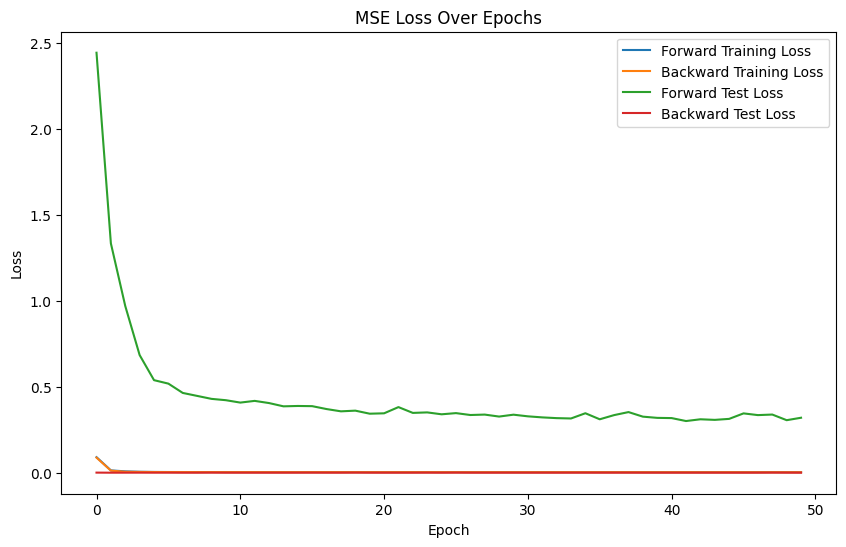

In [112]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    print("Running on GPU")
else: print("Running on CPU")

criterion = nn.MSELoss()
num_epochs = 50

# Forward Model Initialization and Training 
model = SimpleRNN(input_size=6, hidden_size=20, output_size=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_values_fwd_train, loss_values_fwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    model=model,
    train_loader=train_loader_fwd,
    test_loader=test_loader_fwd
              )

# Backward Model Initialization and Training
model = SimpleRNN(input_size=6, hidden_size=20, output_size=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_values_bkwd_train, loss_values_bkwd_test = training_loop(
    num_epochs=num_epochs,
    device=device,
    optimizer=optimizer,
    criterion=criterion,
    model=model,
    train_loader=train_loader_bkwd,
    test_loader=test_loader_bkwd
              )

plt.figure(figsize=(10, 6))
plt.plot(loss_values_fwd_train, label='Forward Training Loss')
plt.plot(loss_values_bkwd_train, label='Backward Training Loss')
plt.plot(loss_values_fwd_test, label='Forward Test Loss')
plt.plot(loss_values_bkwd_test, label='Backward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE Loss Over Epochs')
plt.legend()
plt.show()

### Thoughts
So I have run this forward and backward at a number of different forecasting intervals (1 day, 1 week, 1 month, and 90 days). Although as I increase the distance of prediction the Loss does seem to increase, going forward and backward don't seem to indicate any difference in convergence rates. 

## Transformer

### Model Definition

In [33]:
import torch
import torch.nn as nn
import math

class TransformerModel(nn.Module):
    def __init__(self, input_size, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.encoder = nn.Linear(input_size, input_size)  # Assuming input is already a feature vector
        self.pos_encoder = PositionalEncoding(input_size, dropout)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead, 
                                       dim_feedforward=nhid, dropout=dropout),
            num_layers=nlayers)
        self.decoder = nn.Linear(input_size, 1)  # Output is a single value
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.encoder.bias.data.zero_()
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.encoder(src)  # Ensure input is properly sized
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output[:, -1, :])  # Decode the last output of the sequence
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


In [66]:
# Parameters for the model
input_size = 6  # same as seq_length
nhead = 2
nhid = 64
nlayers = 2
dropout = 0.2
num_epochs = 50

model = TransformerModel(input_size, nhead, nhid, nlayers, dropout).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))


/Users/chrisguarino/opt/anaconda3/envs/predictpast/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [67]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, test_loader, num_epochs):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Lists to store loss values for plotting
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store train loss for this epoch
        
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                val_loss = criterion(outputs.squeeze(), targets)
                total_test_loss += val_loss.item()
        
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)  # Store test loss for this epoch

        print(f'Epoch [{epoch + 1}/{num_epochs}]: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')
    
    return train_losses, test_losses  # Return the loss lists for plotting


In [68]:
def reset_weights(m):
    if isinstance(m, nn.Linear):
        m.reset_parameters()

### Forward and Backward Training

Epoch [1/50]: Train Loss: 0.1664, Test Loss: 3.0008
Epoch [2/50]: Train Loss: 0.0149, Test Loss: 1.7077
Epoch [3/50]: Train Loss: 0.0079, Test Loss: 1.1647
Epoch [4/50]: Train Loss: 0.0057, Test Loss: 0.9000
Epoch [5/50]: Train Loss: 0.0049, Test Loss: 0.7972
Epoch [6/50]: Train Loss: 0.0045, Test Loss: 0.7466
Epoch [7/50]: Train Loss: 0.0043, Test Loss: 0.7026
Epoch [8/50]: Train Loss: 0.0042, Test Loss: 0.6814
Epoch [9/50]: Train Loss: 0.0040, Test Loss: 0.6759
Epoch [10/50]: Train Loss: 0.0039, Test Loss: 0.6868
Epoch [11/50]: Train Loss: 0.0038, Test Loss: 0.6756
Epoch [12/50]: Train Loss: 0.0037, Test Loss: 0.6642
Epoch [13/50]: Train Loss: 0.0037, Test Loss: 0.6538
Epoch [14/50]: Train Loss: 0.0037, Test Loss: 0.6452
Epoch [15/50]: Train Loss: 0.0038, Test Loss: 0.6469
Epoch [16/50]: Train Loss: 0.0037, Test Loss: 0.6420
Epoch [17/50]: Train Loss: 0.0036, Test Loss: 0.6235
Epoch [18/50]: Train Loss: 0.0036, Test Loss: 0.6024
Epoch [19/50]: Train Loss: 0.0036, Test Loss: 0.6289
Ep

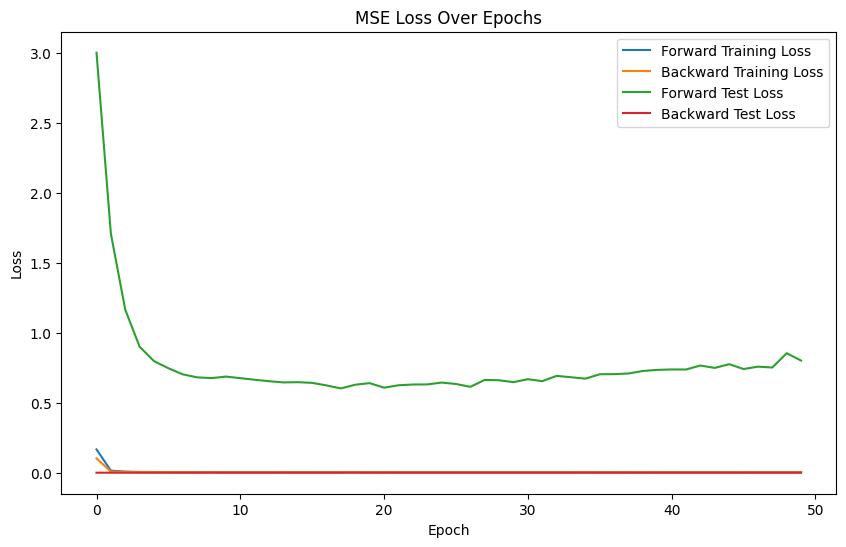

In [111]:
import matplotlib.pyplot as plt

# Assuming train_model has been called and returned loss values for both forward and backward training
model.apply(reset_weights)  # Reset model weights
loss_values_fwd_train, loss_values_fwd_test = train_model(model, train_loader_fwd, test_loader_fwd, num_epochs)
model.apply(reset_weights)  # Reset model weights
loss_values_bkwd_train, loss_values_bkwd_test = train_model(model, train_loader_bkwd, test_loader_bkwd, num_epochs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(loss_values_fwd_train, label='Forward Training Loss')
plt.plot(loss_values_bkwd_train, label='Backward Training Loss')
plt.plot(loss_values_fwd_test, label='Forward Test Loss')
plt.plot(loss_values_bkwd_test, label='Backward Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MSE Loss Over Epochs')
plt.legend()
plt.show()
